In [1]:
from IPython.core.display import HTML
HTML("""
<style>
code {
    padding:2px 4px !important;
    color: #c7254e !important;
    font-size: 90%;
    background-color: #f9f2f4 !important;
    border-radius: 4px !important;
    color: rgb(138, 109, 59);
}
mark {
    color: rgb(138, 109, 59) !important;
    font-weight: bold !important;
}
.container { width: 90% !important; }
table { font-size:15px !important; }
</style>
""")

In [2]:
import sys, math, os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt    
import numpy as np
from scipy import stats
import operator


sys.path.insert(0, '../../src/data/')
import utils

%matplotlib inline
%load_ext autoreload  
%autoreload 2  

path_raw = "../../data/raw/beer_reviews"
savefig = True

assert os.path.isfile(os.path.join(path_raw, 'beer_reviews.csv')), "This data file doesn't exist yet, please run through 'make data'"

# Introduction

The goal of this notebook is to try and answer the question
> Which brewery produces the strongest beers by ABV%?

**NOTE**: analysis [1.0_initial_look](1.0_initial_look.ipynb) identified that various attributes had missing data:
- `beer_abv` not available for all beers
- `brewery_name` not available for each `brewery_id` -> therefore, we should be grouping on `brewery_id`

## Potential issues

1. how to handle missing ABV%?
2. some breweries have only a single beer in this dataset; should we require a minimum number of beers?
3. concerns with noisy reports of ABV%

We being answering this question based on the provided data (and ignoring those beers with no reported ABV), perhaps later we could build a model to predict the ABV for the remaining beers based on the review scores.

In [3]:
# LOAD DATA
# we assume the file we're after is a
# single .csv in path_raw
for file in os.listdir(path_raw):
    file = os.path.join(path_raw, file)
    if os.path.isfile(file) and '.csv' in file: 
        dat_raw = pd.read_csv(file)
        
# DF of beer metadata
beer_meta_cols = ['brewery_id', 'brewery_name','beer_style', 'beer_name','beer_abv']
beer_dat = dat_raw.groupby('beer_beerid').agg('first')[beer_meta_cols]

<hr>

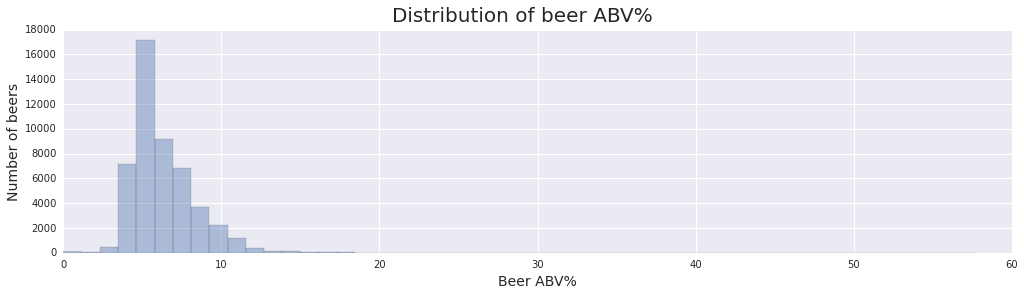

In [4]:
abv = beer_dat[beer_dat.beer_abv.notnull()].sort_values('beer_abv', ascending=False)
utils.draw_hist(abv.beer_abv.tolist(), 
                'Beer ABV%', 
                'Number of beers', 
                'Distribution of beer ABV%')

We being by naivly looking at which brewery has the highest ABV beers without removing any noisy data to get a general sense of the data.

In [5]:
abv_stats = beer_dat[beer_dat.beer_abv.notnull()
                    ].groupby('brewery_id').agg(['count', 
                                                 'min',
                                                 'max',
                                                 'mean',
                                                 'median'])[['beer_abv']]
abv_stats.columns = ['count','min','max','mean','median'] # get rid of multiindex on cols
abv_stats.sort_values('max', ascending=False).head(5)

,count,min,max,mean,median
brewery_id,,,,,
6513,10,4.9,57.7,24.690000,16.0
16315,89,0.5,41.0,9.301910,8.7
15237,46,2.0,39.0,10.130435,10.0
173,32,3.2,29.0,8.896875,10.0
35,97,4.0,27.0,7.641443,5.9


/Library/Python/2.7/site-packages/matplotlib-override/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


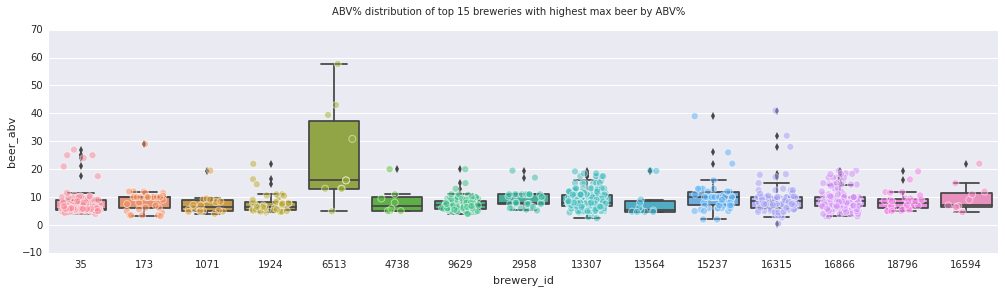

In [6]:
n = 15 # DANGER: magic number
top_breweries_by_abv = abv_stats.sort_values('max', ascending=False).index.tolist()[:15]

tmp = beer_dat[beer_dat.brewery_id.isin(top_breweries_by_abv)]

plt.figure(figsize=(17,4))
ax = sns.boxplot(x="brewery_id", y="beer_abv", data=tmp)
ax = sns.stripplot(x="brewery_id", y="beer_abv", data=tmp, jitter=0.3, alpha=0.5)
plt.suptitle('ABV%% distribution of top %s breweries with highest max beer by ABV%%' %n)
plt.savefig('../reports/figures/2.0_brewery_highest_abv-0.svg')
plt.savefig('../reports/figures/2.0_brewery_highest_abv-0.png')

The plot above shows that many of the brewers with a very high ABV beer contain beers which are considered outliers. Furthermore, brewery *6513* is a clear standout compared to the other top brewers given the fact that is has so few beers to offer, but that for the ones that it does, they have a relatively high ABV on average.

## Remove outliers

For numerous breweries, there seem to be some outlier beers; let's remove outliers using the heuristic of IQR * 1.5

In [7]:
dats = []
for brewery_id, df in beer_dat[beer_dat.beer_abv.notnull()].groupby('brewery_id'):
    # remove any points outside of IQR * 1.5
    tmp = utils.remove_outliers(df.beer_abv)
    
    no_outliers = beer_dat.loc[tmp.index]
    dats.append(no_outliers)
    
without_outliers = pd.concat(dats)
without_outliers[['beer_abv']].describe()

,beer_abv
count,46478.000000
mean,6.183248
std,1.864757
min,0.080000
25%,5.000000
50%,5.600000
75%,7.000000
max,57.700000


In [8]:
abv_stats_no_outliers = without_outliers.groupby('brewery_id').agg(['count', 
                                                 'min',
                                                 'max',
                                                 'mean',
                                                 'median'])[['beer_abv']]
abv_stats_no_outliers.columns = ['count','min','max','mean','median'] # get rid of multiindex on cols
abv_stats_no_outliers.sort_values('max', ascending=False).head(5)

,count,min,max,mean,median
brewery_id,,,,,
6513,10,4.90,57.7,24.690000,16.0
351,3,5.00,18.0,11.066667,10.2
10796,27,4.00,18.0,8.359259,6.2
11031,119,3.50,17.4,8.941597,9.2
2097,138,3.25,16.5,8.061957,7.1


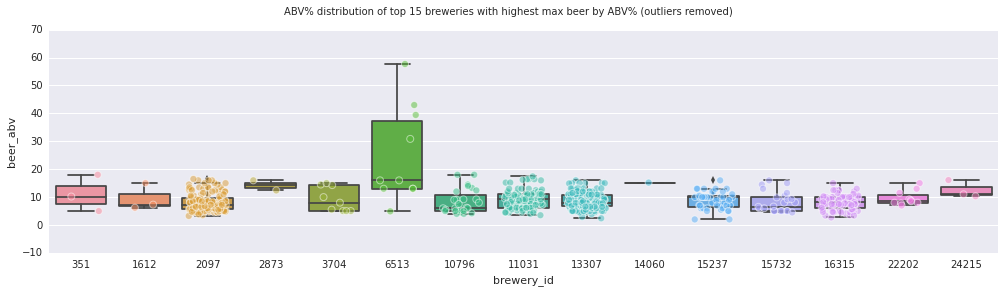

In [9]:
n = 15 # DANGER: magic number
top_breweries_by_abv_no_outliers = abv_stats_no_outliers.sort_values('max', ascending=False).index.tolist()[:n]

tmp = without_outliers[without_outliers.brewery_id.isin(top_breweries_by_abv_no_outliers)]

plt.figure(figsize=(17,4))
ax = sns.boxplot(x="brewery_id", y="beer_abv", data=tmp)
ax = sns.stripplot(x="brewery_id", y="beer_abv", data=tmp, jitter=0.3, alpha=0.5)
plt.suptitle('ABV%% distribution of top %s breweries with highest max beer by ABV%% (outliers removed)' %n)
plt.savefig('../reports/figures/2.0_brewery_highest_abv-1.svg')
plt.savefig('../reports/figures/2.0_brewery_highest_abv-1.png')

In [10]:
# let's bin the breweries by the number of beers they have in the dataset
# and check who has the highest ABV beer based on those bins
bins = 50 # DANGER: magic number
abv_stats_no_outliers.loc[:,'bin'] = pd.cut(abv_stats_no_outliers['count'], bins, labels=False)
bin_edges = {brewery_id:edges for brewery_id,edges in pd.cut(abv_stats_no_outliers['count'], bins, retbins=False).iteritems()}
best_per_group_no_outliers = []
for bin,dat in abv_stats_no_outliers.groupby('bin'):
    tmp = dat.sort_values('max', ascending=False)
    brewery_id = tmp.index.tolist()[0]
    best_per_group_no_outliers.append(brewery_id)
    abv = tmp['max'].tolist()[0]
    edges = bin_edges[brewery_id]
    print 'Brewery %s has highest ABV%% beer (%s) in group of breweries with %s beers available.' %(brewery_id, abv, edges)

Brewery 6513 has highest ABV% beer (57.7) in group of breweries with (0.5, 11] beers available.
Brewery 13371 has highest ABV% beer (15.0) in group of breweries with (11, 21] beers available.
Brewery 10796 has highest ABV% beer (18.0) in group of breweries with (21, 31] beers available.
Brewery 262 has highest ABV% beer (15.0) in group of breweries with (31, 41] beers available.
Brewery 15237 has highest ABV% beer (16.0) in group of breweries with (41, 51] beers available.
Brewery 6288 has highest ABV% beer (15.0) in group of breweries with (51, 61] beers available.
Brewery 12547 has highest ABV% beer (14.0) in group of breweries with (61, 71] beers available.
Brewery 3835 has highest ABV% beer (14.7) in group of breweries with (71, 81] beers available.
Brewery 16315 has highest ABV% beer (15.0) in group of breweries with (81, 91] beers available.
Brewery 10099 has highest ABV% beer (14.0) in group of breweries with (91, 101] beers available.
Brewery 1432 has highest ABV% beer (12.0) i

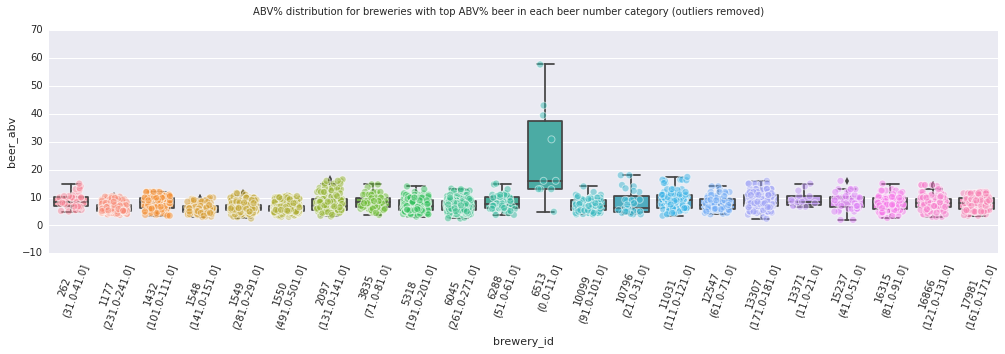

In [11]:
tmp = without_outliers[without_outliers.brewery_id.isin(best_per_group_no_outliers)]

plt.figure(figsize=(17,4))
ax = sns.boxplot(x="brewery_id", y="beer_abv", data=tmp)
ax = sns.stripplot(x="brewery_id", y="beer_abv", data=tmp, jitter=0.3, alpha=0.5)

# add beer range for each bin
labels = [item.get_text() for item in ax.get_xticklabels()]
labels_clean = []
for l in labels:
    edges = bin_edges[int(l)].split(', ')
    low = math.floor(float(edges[0].replace('(','')))
    high = math.ceil(float(edges[1].replace(']','')))
    labels_clean.append(l + '\n(' + str(low) + '-' + str(high) + ']')
ax.set_xticklabels(labels_clean)

plt.suptitle('ABV% distribution for breweries with top ABV% beer in each beer number category (outliers removed)')
plt.xticks(rotation=70)
plt.savefig('../reports/figures/2.0_brewery_highest_abv-2.svg')
plt.savefig('../reports/figures/2.0_brewery_highest_abv-2.png')

The data looks appreciably more consistent with the data removed. The question is vague regarding a minimum number of beers required in order for the brewery to be considered - therefore we've grouped the breweries by the total number of beers they have on tap. Each of these groups is shown in the plot above: brewery *2097* looks interesting in that it has a concentration of beers in the high ABV range.

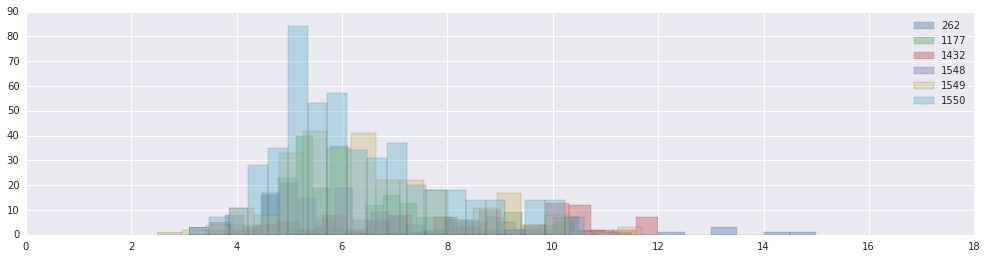

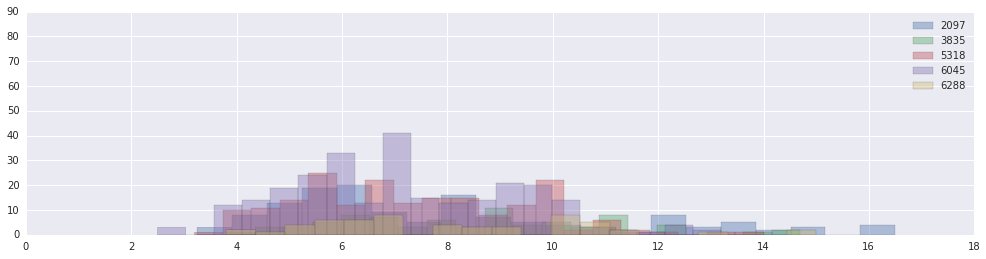

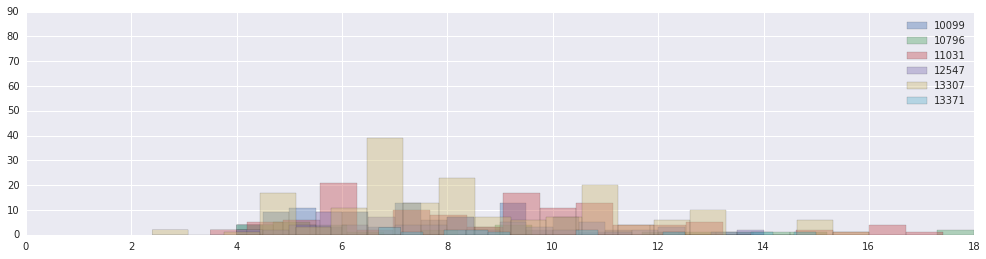

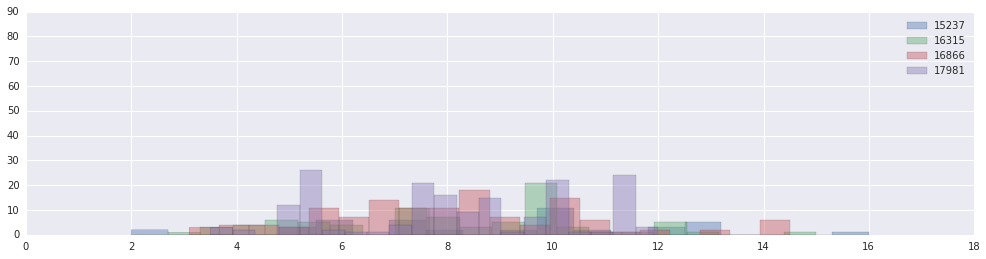

In [12]:
for i, (brewery, df) in enumerate(tmp.groupby('brewery_id')):
    if not i%6: plt.figure(figsize=(17,4))
    if brewery != 6513:
        ax = sns.distplot(df[['beer_abv']], kde=False, label=str(brewery), bins=20)
        ax.legend()
        ax.set_xlim([0,18])
        ax.set_ylim([0,90])


# ax = sns.stripplot(x="brewery_id", y="beer_abv", data=tmp, jitter=0.3, alpha=0.5)

## Remove brewery 6513 & those with a low beer count

In [13]:
min_required_beers = 5 # DANGER: magic number
beer_counts = without_outliers.groupby('brewery_id').count()[['brewery_name']]

without_6513 = without_outliers[(without_outliers.brewery_id!=6513) & 
                                (without_outliers.brewery_id.isin(beer_counts[beer_counts.brewery_name>=min_required_beers].index))]
abv_stats_no_outliers_6513 = without_6513.groupby('brewery_id').agg(['count', 
                                                 'min',
                                                 'max',
                                                 'mean',
                                                 'median'])[['beer_abv']]
abv_stats_no_outliers_6513.columns = ['count','min','max','mean','median'] # get rid of multiindex on cols
abv_stats_no_outliers_6513.sort_values('max', ascending=False).head(5)

,count,min,max,mean,median
brewery_id,,,,,
10796,27,4.00,18.0,8.359259,6.2
11031,119,3.50,17.4,8.941597,9.2
2097,138,3.25,16.5,8.061957,7.1
15732,23,4.50,16.0,8.243478,6.6
13307,176,2.40,16.0,8.453182,8.0


In [14]:
without_6513[['beer_abv']].describe()

,beer_abv
count,40355.000000
mean,6.275659
std,1.860330
min,0.080000
25%,5.000000
50%,5.800000
75%,7.200000
max,18.000000


95th percentile:  14.48


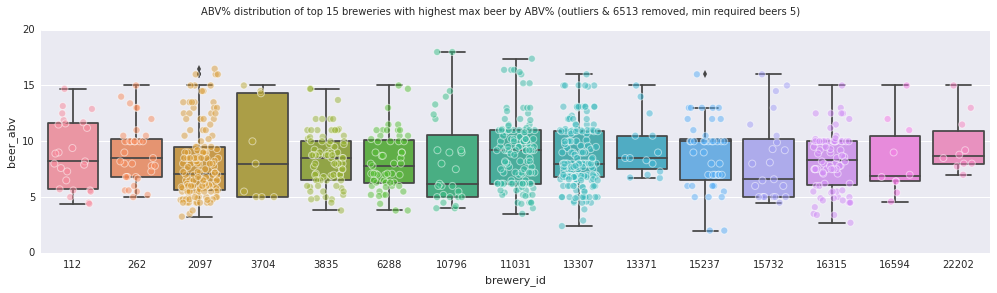

In [15]:
n = 15 # DANGER: magic number

top_breweries_by_abv_no_outliers_6513 = abv_stats_no_outliers_6513.sort_values('max', 
                                                                               ascending=False).index.tolist()[:n]

tmp = without_6513[without_6513.brewery_id.isin(top_breweries_by_abv_no_outliers_6513)]

perc_95 = tmp[['beer_abv']].quantile(0.95).values[0]
print '95th percentile: ', perc_95

plt.figure(figsize=(17,4))
ax = sns.boxplot(x="brewery_id", y="beer_abv", data=tmp)
ax = sns.stripplot(x="brewery_id", y="beer_abv", data=tmp, jitter=0.3, alpha=0.5)
plt.suptitle('ABV%% distribution of top %s breweries with highest max beer by ABV%% (outliers & 6513 removed, min required beers %s)' %(n, min_required_beers))
plt.savefig('../reports/figures/2.0_brewery_highest_abv-3.svg')
plt.savefig('../reports/figures/2.0_brewery_highest_abv-3.png')

In [16]:
# get the count of beers in the 95% percentile for these breweries
tmp.to_csv('../../data/interim/high_beer_ABV_breweries.csv')
beer_counts = tmp[tmp.beer_abv > perc_95].groupby('brewery_id').count()[['brewery_name']]
beer_counts.columns = ['num_beers_above_95_percentile']
beer_counts.sort_values('num_beers_above_95_percentile', ascending=False).head(5)

,num_beers_above_95_percentile
brewery_id,
2097,9
11031,8
13307,7
10796,3
15732,3


In [17]:
# let's get a count for the number of beers that each brewery has
# above some quantile cutoff
dfs = {}
for quant in np.arange(0.9,1.0,0.01):
    quant_counts = {} # {brewery_id: num_beers_in_quantile}
    for brewery,df in tmp.groupby('brewery_id'):
        quant_val = df[['beer_abv']].quantile(quant).values[0]
        count_beers = df[df.beer_abv > quant_val].shape[0] # number of beers in the quantile specified
        quant_counts[brewery] = count_beers

    dfs[quant] = quant_counts

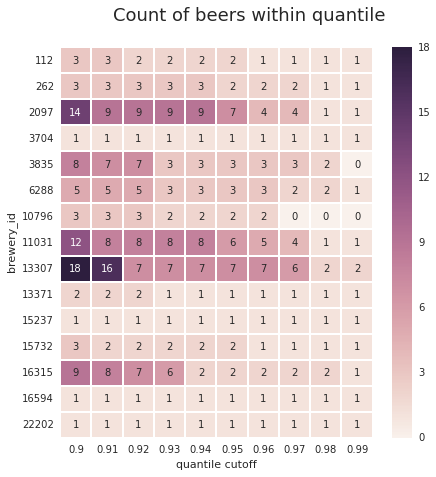

In [18]:
quant_counts = pd.DataFrame(dfs)
quant_counts.index.name = 'brewery_id'
quant_counts.columns.name = 'quantile cutoff'

plt.figure(figsize=(7,7))
with sns.axes_style("white"):
    sns.heatmap(quant_counts, linewidths=.5, annot=True)
    
plt.suptitle('Count of beers within quantile', fontsize=18)
plt.savefig('../reports/figures/2.0_brewery_highest_abv-4.svg')
plt.savefig('../reports/figures/2.0_brewery_highest_abv-4.png')

Three breweries stand out (*13307*, *11031* and *2097*) as having a high number of beers in their respective 90% percentile. Note, though, that this approach is thrown off by the fact that *13307* has a distribution that is skewed to the rigth, whereas *11031* is skewed to the left.

In [19]:
# let's bin the breweries by the number of beers they have in the dataset
# and check who has the highest ABV beer based on those bins
bins = 50 # DANGER: magic number
abv_stats_no_outliers_6513.loc[:,'bin'] = pd.cut(abv_stats_no_outliers_6513['count'], bins, labels=False)
bin_edges = {brewery_id:edges for brewery_id,edges in pd.cut(abv_stats_no_outliers_6513['count'], bins, retbins=False).iteritems()}
best_per_group_no_outliers_6513 = []
for bin,dat in abv_stats_no_outliers_6513.groupby('bin'):
    tmp = dat.sort_values('max', ascending=False)
    brewery_id = tmp.index.tolist()[0]
    best_per_group_no_outliers_6513.append(brewery_id)
    abv = tmp['max'].tolist()[0]
    edges = bin_edges[brewery_id]
    print 'Brewery %s has highest ABV%% beer (%s) in group of breweries with %s beers available.' %(brewery_id, abv, edges)

Brewery 16594 has highest ABV% beer (15.0) in group of breweries with (4.504, 14.92] beers available.
Brewery 15732 has highest ABV% beer (16.0) in group of breweries with (14.92, 24.84] beers available.
Brewery 10796 has highest ABV% beer (18.0) in group of breweries with (24.84, 34.76] beers available.
Brewery 15237 has highest ABV% beer (16.0) in group of breweries with (34.76, 44.68] beers available.
Brewery 2210 has highest ABV% beer (13.0) in group of breweries with (44.68, 54.6] beers available.
Brewery 6288 has highest ABV% beer (15.0) in group of breweries with (54.6, 64.52] beers available.
Brewery 199 has highest ABV% beer (14.0) in group of breweries with (64.52, 74.44] beers available.
Brewery 16315 has highest ABV% beer (15.0) in group of breweries with (74.44, 84.36] beers available.
Brewery 385 has highest ABV% beer (13.25) in group of breweries with (84.36, 94.28] beers available.
Brewery 10099 has highest ABV% beer (14.0) in group of breweries with (94.28, 104.2] beer

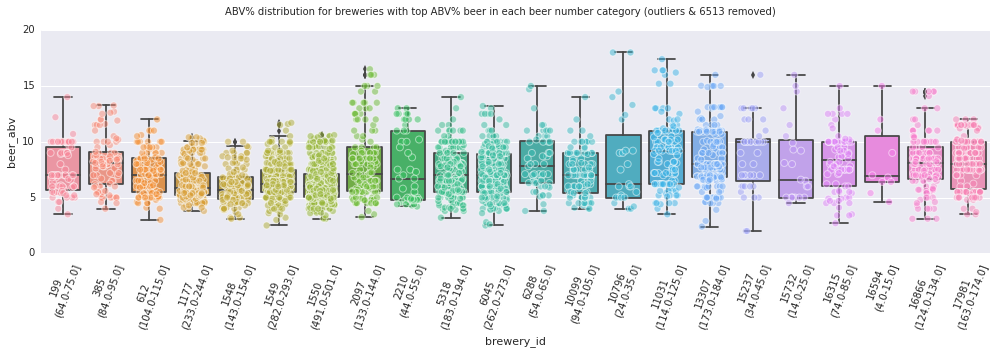

In [20]:
tmp = without_6513[without_6513.brewery_id.isin(best_per_group_no_outliers_6513)]

plt.figure(figsize=(17,4))
ax = sns.boxplot(x="brewery_id", y="beer_abv", data=tmp)
ax = sns.stripplot(x="brewery_id", y="beer_abv", data=tmp, jitter=0.3, alpha=0.5)

# add beer range for each bin
labels = [item.get_text() for item in ax.get_xticklabels()]
labels_clean = []
for l in labels:
    edges = bin_edges[int(l)].split(', ')
    low = math.floor(float(edges[0].replace('(','')))
    high = math.ceil(float(edges[1].replace(']','')))
    labels_clean.append(l + '\n(' + str(low) + '-' + str(high) + ']')
ax.set_xticklabels(labels_clean)

plt.suptitle('ABV% distribution for breweries with top ABV% beer in each beer number category (outliers & 6513 removed)')
plt.xticks(rotation=70)
plt.savefig('../reports/figures/2.0_brewery_highest_abv-5.svg')
plt.savefig('../reports/figures/2.0_brewery_highest_abv-5.png')

11031/2097 looks like a good contender for most strong beers